# Activism EDA

In [60]:
import pyodbc
import pandas as pd
import numpy as np
import pyMechkar as mechkar
import pandas_profiling
import math
from collections import Counter
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
import pyodbc
conn = pyodbc.connect ("DSN=Activism;"
                      "Server=DESKTOP-AAGNMGA\\SQLEXPRESS;"
                      "Database=Activism;"
                      "Trusted_Connection=yes;")

In [4]:
### Get the ff table
#cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM dbo.activist_holdings_v_SC",conn)
df.head()

,Investor ID,Activist,ActivistHQ,ActivistRegion,Founded,FirstDateInvestedByActivisit,CurrentHolding,StatusCurrent,StatusExisted,DateExited,...,SeatsGainedMethod,Ongoing,WithdrewDemands,PartiallySuccessful,Successful,Unsuccessful,CompromiseOrSettlement,Unresolved,Buyer,Succession
0,2,Aberdeen Asset Management PLC,UK,WestEurope,1983.0,2017-01-03,NaN,1,0,None,...,N/A,No,No,No,No,Yes,No,No,None,0
1,2,Aberdeen Asset Management PLC,UK,WestEurope,1983.0,2010-09-10,11.0,1,0,None,...,N/A,No,No,No,Yes,No,No,No,None,0
2,2,Aberdeen Asset Management PLC,UK,WestEurope,1983.0,2015-09-17,NaN,0,1,2016-10-10,...,N/A,No,No,No,Yes,No,No,No,AB InBev,1
3,2,Aberdeen Asset Management PLC,UK,WestEurope,1983.0,2013-08-15,NaN,1,0,None,...,None,No,No,No,No,No,No,No,None,0
4,14,AFL-CIO,US,NorthAmerica,1955.0,2013-03-25,NaN,1,0,None,...,N/A,No,No,No,No,Yes,No,No,None,0


In [6]:
summary = df.describe()
summary = summary.transpose()
summary

,count,mean,std,min,25%,50%,75%,max
Investor ID,9299.0,5541.557049,1959.366931,2.0,5087.0000,5760.00,6621.00,11059.00
Founded,7747.0,1995.264489,28.975312,1668.0,1993.0000,2001.00,2008.00,2020.00
CurrentHolding,3436.0,8.373591,11.124484,0.0,1.2875,4.99,10.01,90.14
StatusCurrent,9299.0,0.487042,0.499859,0.0,0.0000,0.00,1.00,1.00
StatusExisted,9299.0,0.512958,0.499859,0.0,0.0000,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...
ConsentSolicitationInitiated,9292.0,0.000215,0.014670,0.0,0.0000,0.00,0.00,1.00
SECFiling,9292.0,0.000108,0.010374,0.0,0.0000,0.00,0.00,1.00
SeatsProposed,2675.0,2.668037,1.952044,0.0,1.0000,2.00,3.00,20.00
SeatsGained,2630.0,1.349810,1.579656,0.0,0.0000,1.00,2.00,20.00


In [7]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df,minimal=True)
prof.to_file(output_file='output.html')
prof.to_notebook_iframe()

In [61]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

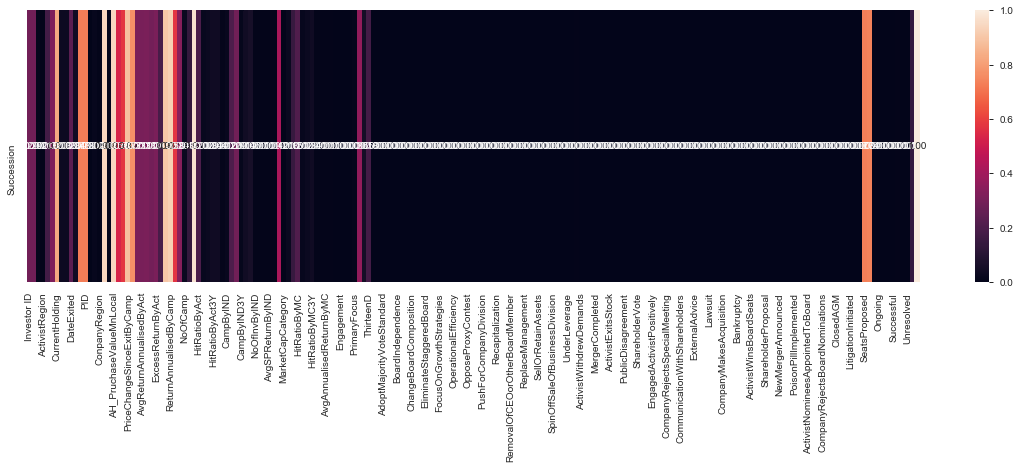

In [67]:
theilu = pd.DataFrame(index=['Succession'],columns=df.columns)
columns = df.columns
for j in range(0,len(columns)):
    u = theil_u(df['Succession'].tolist(),df[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,5))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()